In [21]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 1. Data cleaning 

Purpose: tidy **product_info.csv** into an analysis-ready table.

Main steps: drop noisy columns `cols_to_drop`, remove rows missing `rating` or `ingredients`, normalize category hierarchy (fill secondary/tertiary), parse `highlights` and `ingredients` into lists and counts.

Outputs: **products_cleaned_base.csv**, **highlight_tag_counts.csv**, **ingredient_token_counts.csv**.

In [2]:
# ----------------------------------------------------
# 1. Load our data
# ----------------------------------------------------

INPUT_PATH = "data/product_info.csv"
OUTPUT_CLEANED_PATH = "products_cleaned_base.csv"
OUTPUT_HIGHLIGHT_COUNTS = "highlight_tag_counts.csv"
OUTPUT_INGREDIENT_COUNTS = "ingredient_token_counts.csv"

df = pd.read_csv(INPUT_PATH)

# ----------------------------------------------------
# 2. Drop unwanted columns
# ----------------------------------------------------
cols_to_drop = [
    "size",
    "variation_type",
    "variation_value",
    "variation_desc",
    "value_price_usd",
    "sale_price_usd",
    "child_max_price",
    "child_min_price",
]

df = df.drop(columns=cols_to_drop, errors="ignore")

# ----------------------------------------------------
# 3. Drop rows with NaN in rating or ingredients
# ----------------------------------------------------
df = df[df["rating"].notna()]
df = df[df["ingredients"].notna()]

# ----------------------------------------------------
# 4. Clean category hierarchy: primary / secondary / tertiary
# ----------------------------------------------------

def fill_secondary(row):
    sec = row.get("secondary_category")
    if pd.isna(sec):
        prim = row.get("primary_category", "Unknown")
        return f"{prim} General"
    return sec

df["secondary_category"] = df.apply(fill_secondary, axis=1)

# Ttreat NaNs as "General"
if "tertiary_category" in df.columns:
    df["tertiary_category"] = df["tertiary_category"].fillna("General")

# ----------------------------------------------------
# 5. Parse 'highlights' column and prepare tag selection
# ----------------------------------------------------
def parse_list_string(x):
    """
    Safely parse a string that looks like a Python list, e.g.
    "['Vegan', 'Matte Finish']" -> ['Vegan', 'Matte Finish'].
    If NaN or parsing fails, return [].
    """
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return parsed
        else:
            return []
    except Exception:
        
        return []

# New column with parsed highlights as list
if "highlights" in df.columns:
    df["highlights_list"] = df["highlights"].apply(parse_list_string)
else:
    df["highlights_list"] = [[] for _ in range(len(df))]

# Count all highlight tags
all_highlight_tags = [
    tag.strip()
    for tags in df["highlights_list"]
    for tag in tags
    if isinstance(tag, str)
]

highlight_counter = Counter(all_highlight_tags)


highlight_counts_df = (
    pd.DataFrame(
        [{"tag": tag, "count": count} for tag, count in highlight_counter.most_common()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

highlight_counts_df.to_csv(OUTPUT_HIGHLIGHT_COUNTS, index=False)
print(f"Saved highlight tag counts to: {OUTPUT_HIGHLIGHT_COUNTS}")
print(highlight_counts_df.head(15))


df["n_highlights"] = df["highlights_list"].apply(len)

# ----------------------------------------------------
# 6. Parse 'ingredients' and data-driven refinement
# ----------------------------------------------------

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

# join list and lowercase
def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    # join with commas for separation
    text = ", ".join([str(x) for x in ing_list])
    return text.lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)


ingredient_tokens = []

for text in df["ingredients_text"]:
    if not text:
        continue
   
    parts = text.split(",")
    for p in parts:
        token = p.strip()
        if token:
            ingredient_tokens.append(token)

ingredient_counter = Counter(ingredient_tokens)

# Choose top 200
TOP_N_INGREDIENTS = 200
top_ingredients = ingredient_counter.most_common(TOP_N_INGREDIENTS)

ingredient_counts_df = pd.DataFrame(
    [{"ingredient_token": ing, "count": cnt} for ing, cnt in top_ingredients]
).sort_values("count", ascending=False)

ingredient_counts_df.to_csv(OUTPUT_INGREDIENT_COUNTS, index=False)
print(f"Saved ingredient token counts to: {OUTPUT_INGREDIENT_COUNTS}")
print(ingredient_counts_df.head(15))

# ----------------------------------------------------
# 7. Save base cleaned dataset
# ----------------------------------------------------
df.to_csv(OUTPUT_CLEANED_PATH, index=False)
print(f"Saved cleaned dataset (with parsed highlights/ingredients) to: {OUTPUT_CLEANED_PATH}")


Saved highlight tag counts to: highlight_tag_counts.csv
                                  tag  count
0                               Vegan   2365
1                        Cruelty-Free   1574
2                    Clean at Sephora   1438
3                    Without Parabens   1282
4                   Good for: Dryness   1119
5                           Hydrating   1100
6   Good for: Dullness/Uneven Texture    856
7         Without Sulfates SLS & SLES    727
8                        Long-wearing    686
9             Clean + Planet Positive    658
10                     All Hair Types    632
11               Good for: Anti-Aging    585
12                    Hyaluronic Acid    560
13                 Without Phthalates    479
14                     Fragrance Free    477
Saved ingredient token counts to: ingredient_token_counts.csv
                ingredient_token  count
0                       glycerin   4087
1                 phenoxyethanol   3802
2                caprylyl glycol   2713
3 

In [3]:
df = pd.read_csv("products_cleaned_base.csv")

def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["highlights_list"] = df["highlights"].apply(parse_list_string)

hsel = pd.read_csv("highlight_features_selected.csv")

for tag in hsel["tag"]:
    col_name = "tag_" + tag.lower().replace(" ", "_").replace("/", "_").replace(":", "").replace(",", "").replace("&", "and")
    df[col_name] = df["highlights_list"].apply(lambda tags: int(tag in tags))

df["n_highlights"] = df["highlights_list"].apply(len)


In [4]:
df = pd.read_csv("products_cleaned_base.csv")

def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    return ", ".join([str(x) for x in ing_list]).lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)

isel = pd.read_csv("ingredient_features_selected.csv", sep=";")

group_to_tokens = {}
for _, row in isel.iterrows():
    group = row["group_name"]
    token = str(row["token"]).lower()
    group_to_tokens.setdefault(group, []).append(token)

for group_name, tokens in group_to_tokens.items():
    df[group_name] = df["ingredients_text"].apply(
        lambda txt: int(any(tok in txt for tok in tokens))
    )

df["n_ingredients"] = df["ingredients_text"].apply(
    lambda txt: len([p for p in txt.split(",") if p.strip()])
)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   product_id                    7322 non-null   object 
 1   product_name                  7322 non-null   object 
 2   brand_id                      7322 non-null   int64  
 3   brand_name                    7322 non-null   object 
 4   loves_count                   7322 non-null   int64  
 5   rating                        7322 non-null   float64
 6   reviews                       7322 non-null   float64
 7   ingredients                   7322 non-null   object 
 8   price_usd                     7322 non-null   float64
 9   limited_edition               7322 non-null   int64  
 10  new                           7322 non-null   int64  
 11  online_only                   7322 non-null   int64  
 12  out_of_stock                  7322 non-null   int64  
 13  sep

In [6]:
df.to_csv("products_final.csv", index=False)

# 2. Basic Overview

In [7]:
DATA_PATH = "products_final.csv" 
df = pd.read_csv(DATA_PATH)


print("Shape:", df.shape)
df.head()

Shape: (7322, 42)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,ingredients,price_usd,limited_edition,...,has_antioxidant_vitamins,has_niacinamide,has_caffeine,has_adenosine,has_barrier_soothing,has_chemical_sunscreen,has_mineral_sunscreen,has_common_preservatives,has_hair_conditioning_agents,n_ingredients
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,0,...,0,0,0,0,0,1,0,0,0,94
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,13
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12


## 2.1 Category coverage & spend signals
Understand which categories dominate volume and how price and engagement differ by segment.

In [8]:
product_id_col = "product_id" if "product_id" in df.columns else "product_name"
category_summary = (
    df.groupby("primary_category")
      .agg(
          products=(product_id_col, "nunique"),
          avg_price=("price_usd", "mean"),
          avg_loves=("loves_count", "mean"),
          avg_reviews=("reviews", "mean"),
          avg_rating=("rating", "mean"),
      )
      .sort_values("products", ascending=False)
      .head(10)
      .round(2)
)
category_summary

,products,avg_price,avg_loves,avg_reviews,avg_rating
primary_category,,,,,
Skincare,2224,58.40,28553.74,480.47,4.23
Makeup,1999,33.23,58668.89,747.16,4.14
Hair,1232,35.18,14892.55,276.18,4.22
Fragrance,1186,91.21,14494.89,292.70,4.25
Bath & Body,364,40.85,17803.96,210.18,4.19
Mini Size,257,20.51,28761.14,668.09,4.00
Men,58,32.97,4997.52,73.95,4.50
Tools & Brushes,2,25.00,6086.50,41.50,4.20


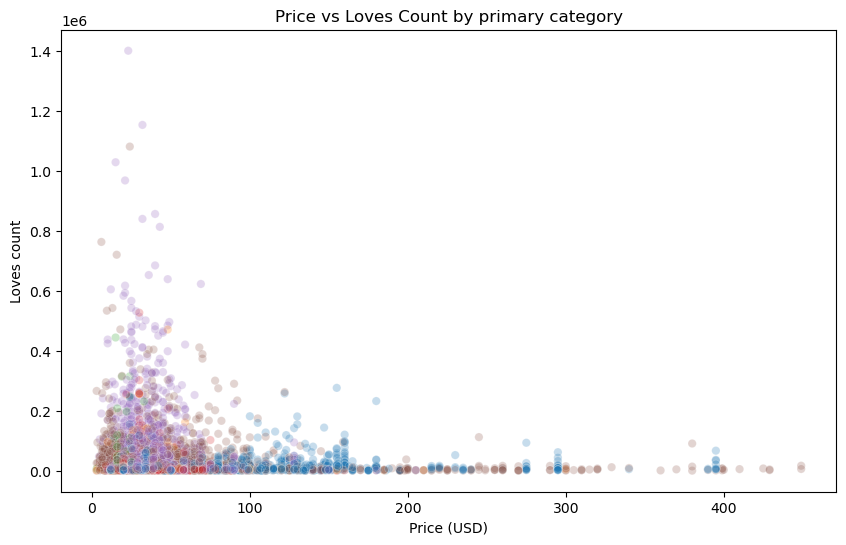

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="price_usd",
    y="loves_count",
    hue="primary_category",
    alpha=0.25,
    legend=False
)
plt.title("Price vs Loves Count by primary category")
plt.xlabel("Price (USD)")
plt.ylabel("Loves count")
plt.show()

In [10]:
num_cols = ["price_usd", "loves_count", "rating", "reviews", "n_highlights", "n_ingredients"]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price_usd,7322.0,50.520610,47.669602,3.0,25.000000,35.00000,58.00000,449.0
loves_count,7322.0,31479.851543,68960.425831,0.0,4285.750000,10849.50000,29041.25000,1401068.0
rating,7322.0,4.199126,0.495827,1.0,3.995875,4.28885,4.52475,5.0
reviews,7322.0,478.301147,1125.133923,1.0,31.000000,144.00000,453.00000,21281.0
n_highlights,7322.0,3.749659,2.407591,0.0,2.000000,5.00000,6.00000,9.0
n_ingredients,7322.0,35.048211,34.133443,1.0,19.000000,28.00000,40.00000,720.0


# 3. EDA

## 3.0 Engagement snapshot
This section connects Sephora's business signals (price, engagement, satisfaction) before we derive the popularity label. We quantify central tendencies, highlight skew/outliers, and examine how price tiers relate to customer response.

Boxplots for numerical variables: 
- `price_usd`: The price of the product in US dollars
- `rating`: The average rating of the product based on user reviews
- `loves_count`: The number of people who have marked this product as a favorite

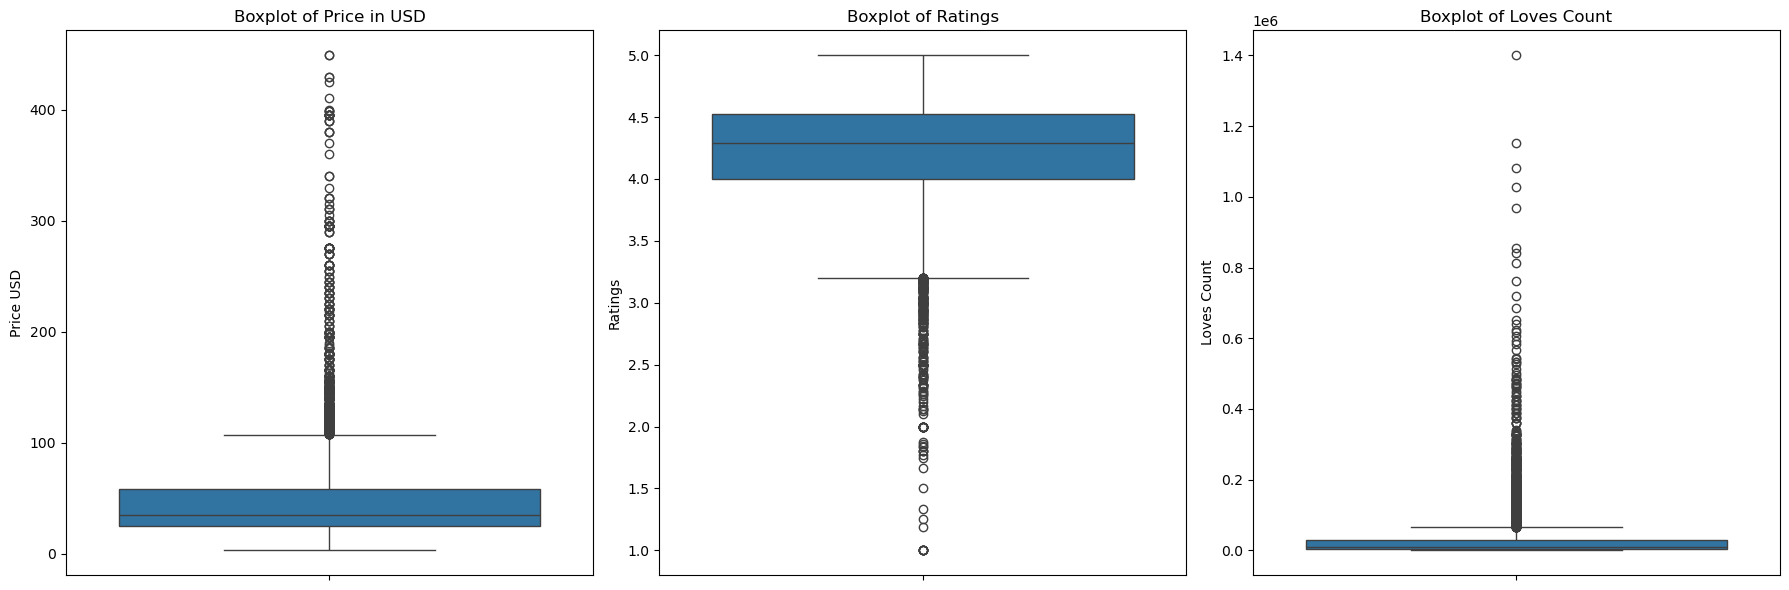

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for 'price_usd'
sns.boxplot(y=df['price_usd'], ax=axes[0])
axes[0].set_title('Boxplot of Price in USD')
axes[0].set_ylabel('Price USD')

# Boxplot for 'rating'
sns.boxplot(y=df['rating'], ax=axes[1])
axes[1].set_title('Boxplot of Ratings')
axes[1].set_ylabel('Ratings')

# Boxplot for 'loves_count'
sns.boxplot(y=df['loves_count'], ax=axes[2])
axes[2].set_title('Boxplot of Loves Count')
axes[2].set_ylabel('Loves Count')

# Display the plots
plt.tight_layout()
plt.show()


Top 10 brands that have the biggest amount of products: 

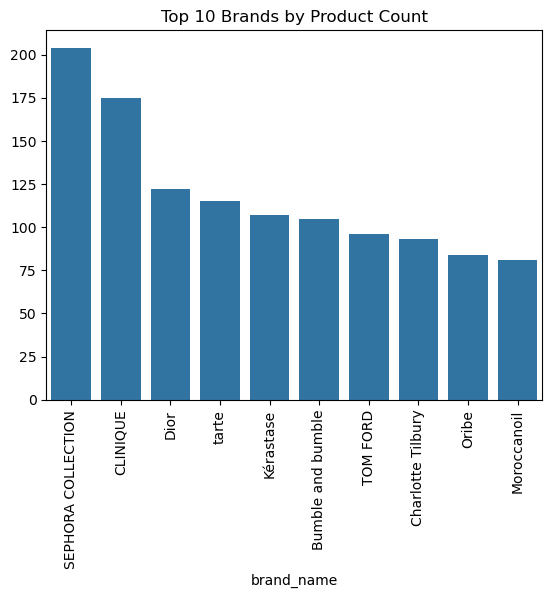

In [12]:
brand_count = df['brand_name'].value_counts().nlargest(10)
sns.barplot(x=brand_count.index, y=brand_count.values)
plt.title('Top 10 Brands by Product Count')
plt.xticks(rotation=90)
plt.show()

Distribution of the price, ratings, and loves count across all products

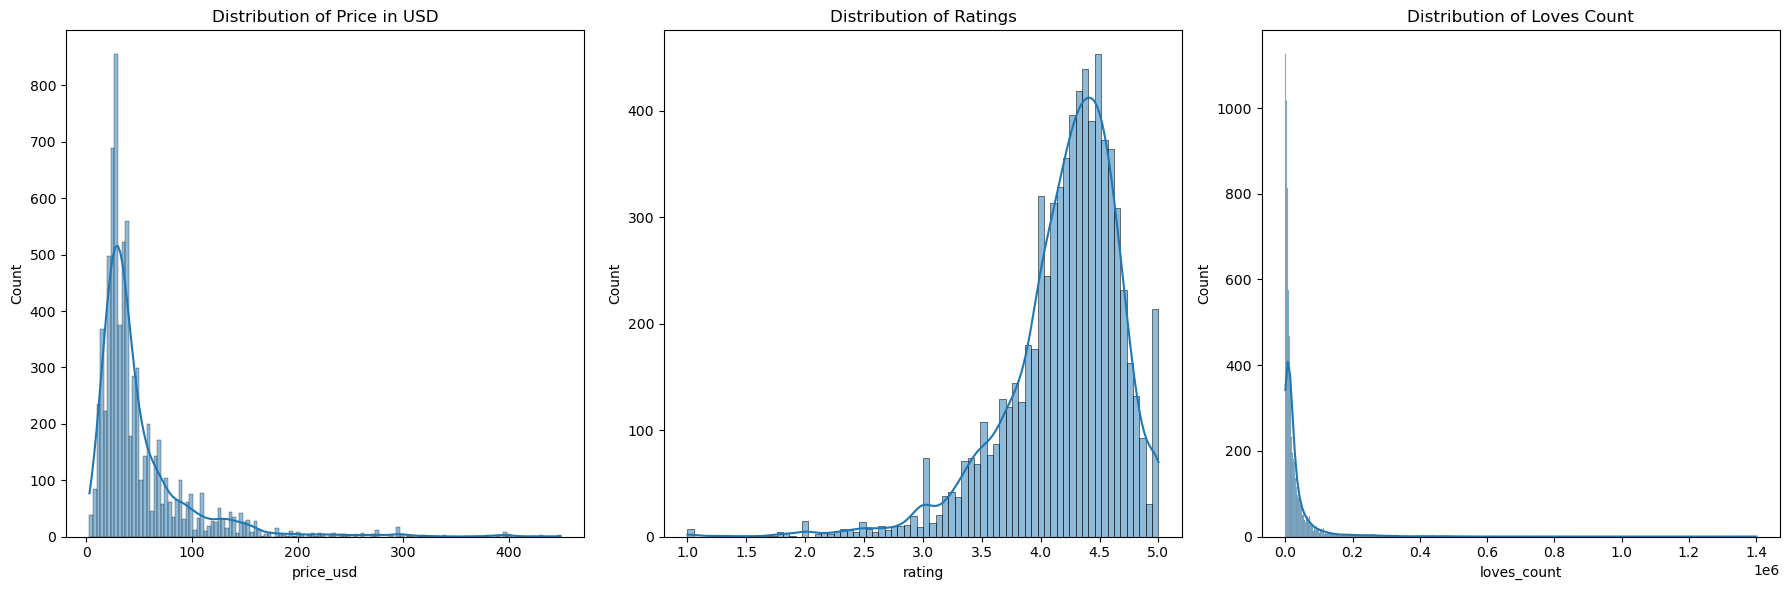

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Price histogram
sns.histplot(df['price_usd'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price in USD')

# Rating histogram
sns.histplot(df['rating'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Ratings')

# Loves count histogram
sns.histplot(df['loves_count'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Loves Count')

plt.tight_layout()
plt.show()

Prive vs rating sactterplot

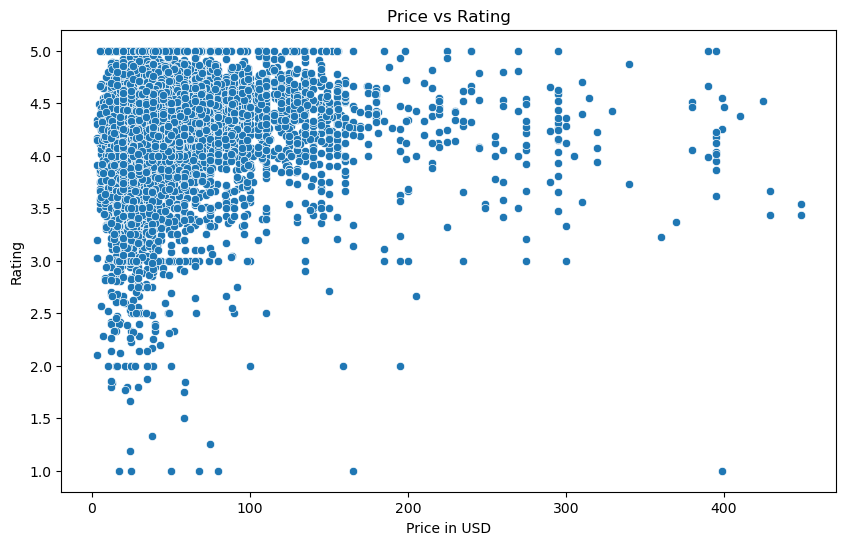

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price_usd', y='rating', data=df)
plt.title('Price vs Rating')
plt.xlabel('Price in USD')
plt.ylabel('Rating')
plt.show()

### Price tiers vs engagement
Segment products into spend tiers to see if premium positioning correlates with customer actions.

In [15]:
price_labels = ["Budget", "Mass", "Prestige", "Luxury"]
price_bins = pd.qcut(df["price_usd"], q=[0, 0.25, 0.5, 0.75, 1], duplicates="drop")
if price_bins.dtype == "O" or len(price_bins.cat.categories) < len(price_labels):
    price_labels = price_labels[:len(price_bins.cat.categories)]
price_segment_col = price_bins.cat.rename_categories(price_labels)

df["price_segment"] = price_segment_col
price_segment_summary = (
    df.groupby("price_segment")
    .agg(
        products=("product_name", "count"),
        avg_loves=("loves_count", "mean"),
        avg_reviews=("reviews", "mean"),
        avg_rating=("rating", "mean"),
        median_price=("price_usd", "median")
    )
    .round(2)
)
price_segment_summary

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_77125/2442587172.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("price_segment")


,products,avg_loves,avg_reviews,avg_rating,median_price
price_segment,,,,,
Budget,1909,38585.40,533.07,4.07,20.0
Mass,1811,32618.54,495.94,4.19,30.0
Prestige,1826,34828.56,533.15,4.25,44.0
Luxury,1776,19238.08,345.05,4.29,90.0


/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_77125/2190911253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="price_segment", y="rating", order=price_labels[:len(df["price_segment"].unique())], palette="pastel", cut=0)


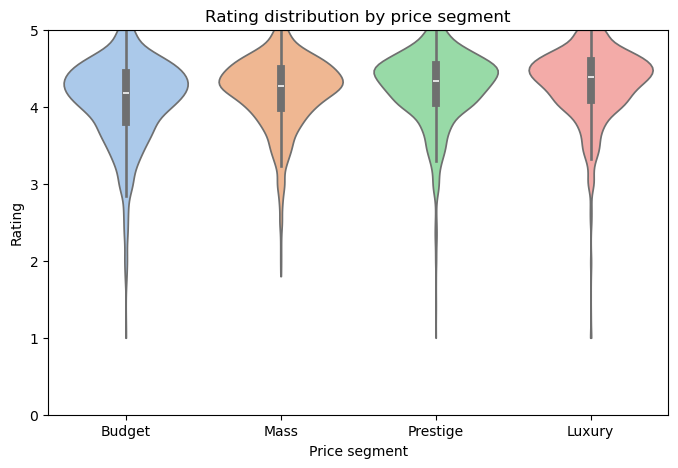

In [16]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="price_segment", y="rating", order=price_labels[:len(df["price_segment"].unique())], palette="pastel", cut=0)
plt.title("Rating distribution by price segment")
plt.xlabel("Price segment")
plt.ylabel("Rating")
plt.ylim(0, 5)
plt.show()

## 3.1 Engagement correlations
Quantify how the main behavioral signals align with one another before defining the final business target.

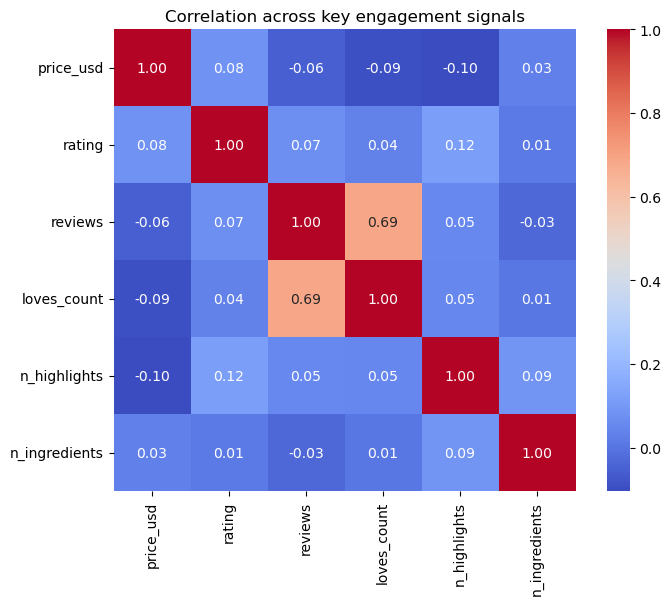

,price_usd,rating,reviews,loves_count,n_highlights,n_ingredients
price_usd,1.000000,0.079010,-0.056744,-0.092535,-0.104400,0.029547
rating,0.079010,1.000000,0.071651,0.037934,0.117010,0.014859
reviews,-0.056744,0.071651,1.000000,0.685993,0.053494,-0.034619
loves_count,-0.092535,0.037934,0.685993,1.000000,0.047820,0.005437
n_highlights,-0.104400,0.117010,0.053494,0.047820,1.000000,0.088142
n_ingredients,0.029547,0.014859,-0.034619,0.005437,0.088142,1.000000


In [17]:
engagement_cols = [
    "price_usd",
    "rating",
    "reviews",
    "loves_count",
    "n_highlights",
    "n_ingredients"
]
existing_cols = [c for c in engagement_cols if c in df.columns]
corr = df[existing_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation across key engagement signals")
plt.show()

corr

## 3.2 Feature engineering hooks
Create reusable metrics that will later help define the engagement target and power the ML models.

In [18]:
df["log_loves"] = np.log1p(df["loves_count"])
df["log_reviews"] = np.log1p(df["reviews"])
df["reviews_per_love"] = df["reviews"] / (df["loves_count"] + 1)
df["price_bucket"] = pd.qcut(df["price_usd"], q=[0, 0.25, 0.5, 0.75, 1], duplicates="drop")

feature_preview = df[["price_usd", "price_bucket", "log_loves", "log_reviews", "reviews_per_love"]].head()
feature_preview

,price_usd,price_bucket,log_loves,log_reviews,reviews_per_love
0,35.0,"(25.0, 35.0]",8.751633,2.484907,0.001740
1,195.0,"(58.0, 449.0]",8.250098,2.639057,0.003396
2,195.0,"(58.0, 449.0]",8.087640,2.833213,0.004917
3,195.0,"(58.0, 449.0]",8.012681,3.091042,0.006956
4,195.0,"(58.0, 449.0]",7.898040,2.639057,0.004829


# 4. Popularity Score 

First we need to do some scaling for the rating , as some products might have a super small amount of reviews and still have a rating of 5 

In [19]:
df['scaled_rating'] = df['rating'] * (df['reviews'] / df['reviews'].max())

Now we define the popularity score as a normalized blend of the three engagement signals (`loves_count`, review-adjusted rating, and `reviews`). Rather than hand-picking weights, we let the data drive the importance: features with higher variability (after scaling) get slightly more influence because they help discriminate products.

In [22]:
engagement_cols = ["loves_count", "scaled_rating", "reviews"]
scaler = MinMaxScaler()
norm_col_names = [f"{col}_norm" for col in engagement_cols]
df[norm_col_names] = scaler.fit_transform(df[engagement_cols])

feature_stds = df[norm_col_names].std()
feature_weights = (feature_stds / feature_stds.sum()).to_dict()
feature_weights

{'loves_count_norm': 0.31329909644843823,
 'scaled_rating_norm': 0.3501498014160312,
 'reviews_norm': 0.3365511021355307}

Also, we will apply Min-Max scaling to each individual feature before combining them into the popularity score. This way, the popularity score will naturally be within a bounded range.

In [23]:
df['popularity_score'] = 0
for col_norm in norm_col_names:
    weight = feature_weights.get(col_norm, 0)
    df['popularity_score'] += weight * df[col_norm]

df['popularity_score'] = df['popularity_score'].round(4)
df[['popularity_score'] + norm_col_names].head()

,popularity_score,loves_count_norm,scaled_rating_norm,reviews_norm
0,0.0017,0.004511,0.000444,0.000470
1,0.0013,0.002731,0.000603,0.000564
2,0.0012,0.002322,0.000762,0.000705
3,0.0014,0.002154,0.001058,0.000940
4,0.0010,0.001921,0.000466,0.000564


## 4.1 Binary proxy label for early modeling
Use the current popularity score to build a temporary binary label for EDA/feature selection. We flag the **top 30%** (70th percentile and above) because Sephora typically focuses on a manageable slice of hero products; this keeps the positive class big enough for modeling but still highlights the standouts.

In [24]:
# Top 30% (70th percentile) treated as "popular" for exploratory work
PROXY_PERCENTILE = 0.70
proxy_threshold = df['popularity_score'].quantile(PROXY_PERCENTILE)
df['popularity_proxy'] = (df['popularity_score'] >= proxy_threshold).astype(int)

print(f"Proxy threshold ({int((1-PROXY_PERCENTILE)*100)}% most-popular): {proxy_threshold:.3f}")
print(df['popularity_proxy'].value_counts(normalize=True).rename('share'))

Proxy threshold (30% most-popular): 0.018
popularity_proxy
0    0.699809
1    0.300191
Name: share, dtype: float64


/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_77125/1854809614.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='popularity_proxy', data=df, palette=['#999999', '#c51b7d'])


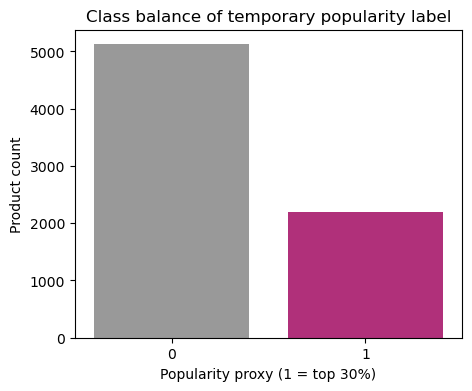

In [25]:
plt.figure(figsize=(5, 4))
sns.countplot(x='popularity_proxy', data=df, palette=['#999999', '#c51b7d'])
plt.title('Class balance of temporary popularity label')
plt.xlabel('Popularity proxy (1 = top 30%)')
plt.ylabel('Product count')
plt.show()

## 4.2 Feature behavior vs popularity proxy

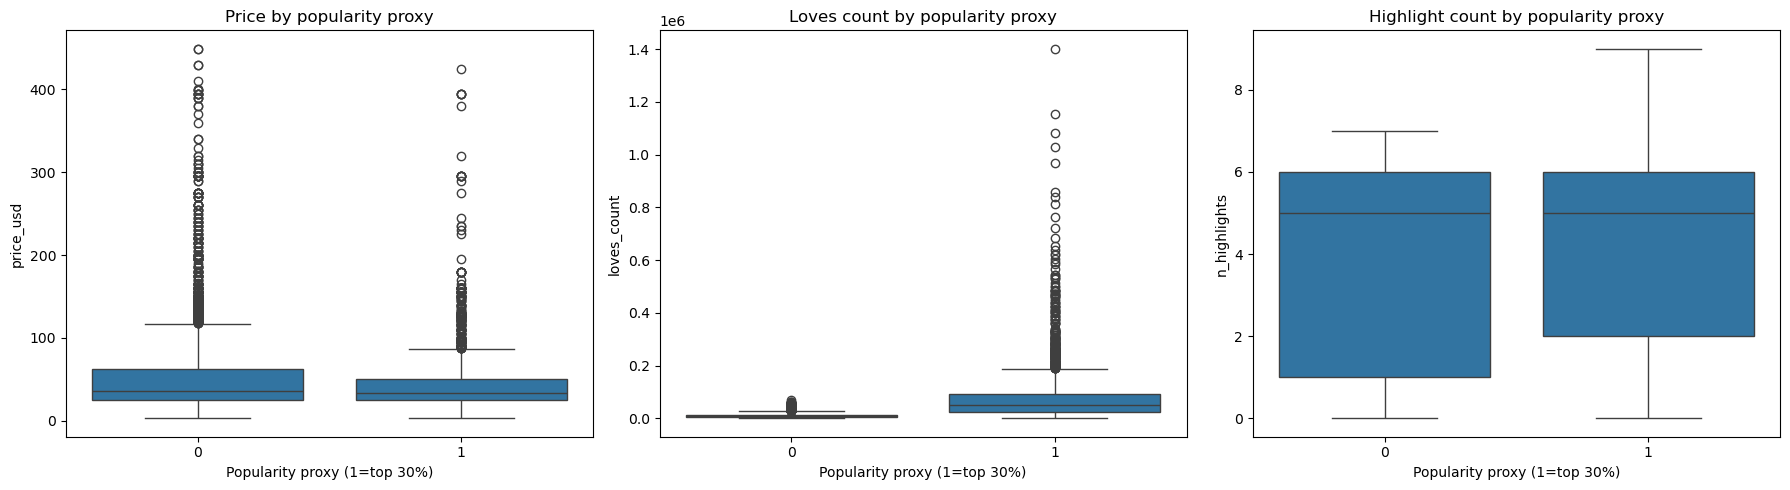

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='popularity_proxy', y='price_usd', data=df, ax=axes[0])
axes[0].set_title('Price by popularity proxy')
sns.boxplot(x='popularity_proxy', y='loves_count', data=df, ax=axes[1])
axes[1].set_title('Loves count by popularity proxy')
sns.boxplot(x='popularity_proxy', y='n_highlights', data=df, ax=axes[2])
axes[2].set_title('Highlight count by popularity proxy')
for ax in axes:
    ax.set_xlabel('Popularity proxy (1=top 30%)')
plt.tight_layout()
plt.show()

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_77125/3426141704.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


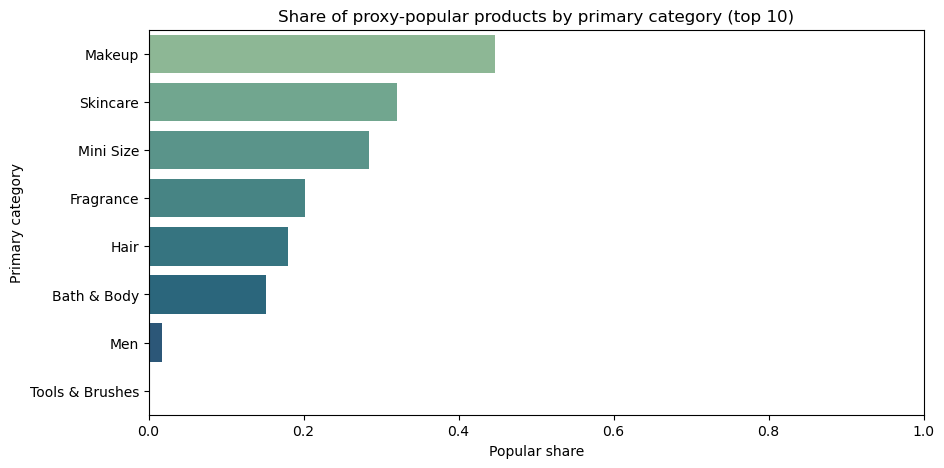

,popular_share,products
primary_category,,
Makeup,0.447224,1999
Skincare,0.321043,2224
Mini Size,0.284047,257
Fragrance,0.201518,1186
Hair,0.180195,1232
Bath & Body,0.151099,364
Men,0.017241,58
Tools & Brushes,0.000000,2


In [27]:
popularity_by_category = (
    df.groupby('primary_category')['popularity_proxy']
      .agg(popular_share='mean', products='count')
      .sort_values('popular_share', ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    y=popularity_by_category.index,
    x=popularity_by_category['popular_share'],
    palette='crest'
)
plt.title('Share of proxy-popular products by primary category (top 10)')
plt.xlabel('Popular share')
plt.ylabel('Primary category')
plt.xlim(0, 1)
plt.show()

popularity_by_category

## 4.3 Highlight & ingredient drivers

In [28]:
def canonicalize_tag(tag: str) -> str:
    return (
        "tag_"
        + tag.lower()
        .replace(" ", "_")
        .replace("/", "_")
        .replace(":", "")
        .replace(",", "")
        .replace("&", "and")
    )

try:
    hsel = pd.read_csv("highlight_features_selected.csv")
    highlight_cols = [canonicalize_tag(tag) for tag in hsel["tag"]]
    highlight_cols = [c for c in highlight_cols if c in df.columns]
except FileNotFoundError:
    highlight_cols = []

highlight_effect_df = pd.DataFrame()

if not highlight_cols:
    print("Highlight feature columns not found. Make sure the highlight dummy columns were created earlier in the notebook.")
else:
    highlight_effect = []
    for col in highlight_cols:
        means = df.groupby(col)["popularity_score"].mean()
        uplift = means.get(1, np.nan) - means.get(0, np.nan)
        highlight_effect.append({
            "feature": col,
            "share": df[col].mean().round(3),
            "avg_popularity_with_tag": means.get(1, np.nan),
            "uplift_vs_no_tag": uplift
        })
    highlight_effect_df = pd.DataFrame(highlight_effect).sort_values(
        "uplift_vs_no_tag", ascending=False
    ).head(10)

highlight_effect_df

Highlight feature columns not found. Make sure the highlight dummy columns were created earlier in the notebook.


""


In [29]:
try:
    isel = pd.read_csv("ingredient_features_selected.csv", sep=";")
    ingredient_group_cols = [grp for grp in isel["group_name"].unique() if grp in df.columns]
except FileNotFoundError:
    ingredient_group_cols = []

ingredient_effect_df = pd.DataFrame()
if not ingredient_group_cols:
    print("Ingredient group columns not found. Ensure the ingredient feature engineering cell was executed.")
else:
    ingredient_effect = []
    for col in ingredient_group_cols:
        means = df.groupby(col)["popularity_score"].mean()
        uplift = means.get(1, np.nan) - means.get(0, np.nan)
        ingredient_effect.append({
            "group": col,
            "share": df[col].mean().round(3),
            "avg_popularity_with_group": means.get(1, np.nan),
            "uplift_vs_no_group": uplift
        })
    ingredient_effect_df = pd.DataFrame(ingredient_effect).sort_values(
        "uplift_vs_no_group", ascending=False
    ).head(10)

ingredient_effect_df

,group,share,avg_popularity_with_group,uplift_vs_no_group
15,has_mineral_sunscreen,0.219,0.033291,0.013507
3,has_silicones,0.354,0.028451,0.008834
16,has_common_preservatives,0.626,0.024091,0.003611
9,has_antioxidant_vitamins,0.528,0.024221,0.003131
4,has_humectants,0.675,0.022459,-0.000876
5,has_emollient_oils,0.438,0.022138,-0.001075
8,has_exfol_acids_bha,0.053,0.020174,-0.002712
14,has_chemical_sunscreen,0.103,0.019410,-0.003715
10,has_niacinamide,0.068,0.019260,-0.003739
13,has_barrier_soothing,0.253,0.018910,-0.005129


# 5. Study the popularity among other factors 


                  popularity_score  n_highlights  n_ingredients  brand_id
popularity_score          1.000000      0.055726      -0.023618 -0.059753
n_highlights              0.055726      1.000000       0.088142  0.311255
n_ingredients            -0.023618      0.088142       1.000000  0.027205
brand_id                 -0.059753      0.311255       0.027205  1.000000


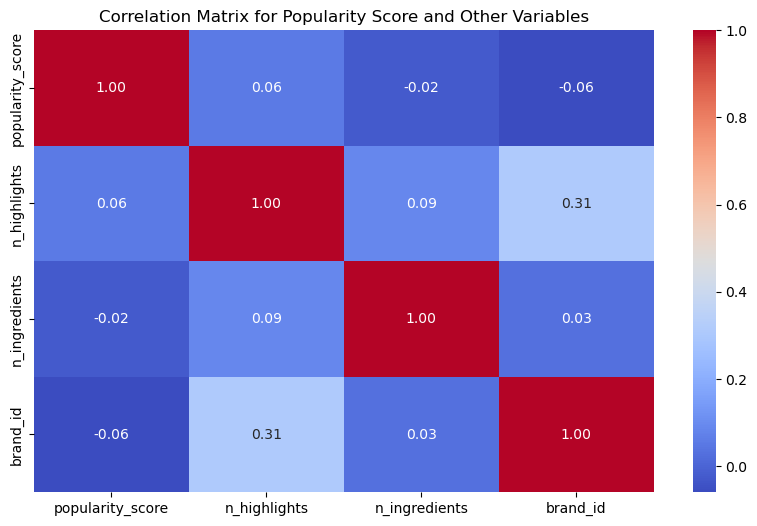

In [30]:
correlation_columns = ['popularity_score',  'n_highlights', 'n_ingredients', 'brand_id']


correlation_matrix = df[correlation_columns].corr()
print(correlation_matrix)


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for Popularity Score and Other Variables')
plt.show()


## 6. EDA takeaways & modeling hand-off
- **Data readiness:** Key columns are now cleaned, typed, and augmented with log / ratio features and price buckets for downstream modeling.
- **Proxy label:** Temporary `popularity_proxy` (top 30% by score) exposes signal concentration across price, highlights, ingredients, and categories; reuse this logic when creating the final business-approved target.
- **Feature signals:** Certain highlight tags / ingredient groups show positive popularity uplift—prioritize these fields when building the ML feature matrix and SHAP explanation set.
- **Next steps:** finalize the popularity label definition with stakeholders, freeze the modeling dataset, train candidate models (e.g., gradient boosting), compute SHAP values for the most important features, and surface the insights plus interactive filtering inside the Streamlit dashboard for Sephora stakeholders.